# Anomaly Detection of Exotic Particle Physics Events at the LHC 





### Introduction:


The Standard model (SM) of Particle Physics is the most complete model physicists have for understanding the interactions of the fundamental particles in the universe.

Though the SM has experimentally stood the test of time, many outstanding questions about the universe and the model itself remain, and scientist continue to probe for inconsistencies in the SM in order to find new physics

The Large Hadron Collider (LHC) is a particle smasher capable of colliding protons at a centre of mass energy of 14 TeV.
**ATLAS** is general purpose particle detectors tasked with recording the remnants of proton collisions at the collicion point. The main purpose of this experiment is to test the SM rigorously, and ATLAS was one of two expeririments (ATLAS+CMS) responsible for the discovery of the **Higgs boson in 2012**. 

---

A particle's kinematics can tbe described by a four-vector  $$\bar{p} = (E,p_T,\eta,\phi)$$

* The azimuth $\phi$ ( angle around the beam, 0 is up)
* Pseudo-rapidity $\eta$ (trajectory along the beam) positions of the particle directions with respect to the interaction point.
* The total energy measured for the particle is denoted by $E$,
* The transverse momentum ($p_T$) deposited by the particle in giga-electronvolts (GeV).


An additional importan quantity is the missing energy in the transverse plane (MET). This is calculated by taking the negative sum of the transverse momentum of all particles in the event.
$$\mathrm{MET} = -\sum p_T$$

With perfect detector performance the MET will sum to 0 if all outgoing particles are observed by the detector. Neutrinos cannot be measured by the detector and hence their precense produces non-zero MET.

---

### Anomally detection dataset

For the anomally detection in this project I use the dataset discussed in this publication: <p><a href="https://arxiv.org/pdf/2105.14027.pdf" title="Anomalies">The Dark Machines Anomaly Score Challenge:
Benchmark Data and Model Independent Event
Classification for the Large Hadron Collider</a></p>

---

The dataset contains a collection of simulated proton-proton collisions in a general particle physics detector (such as ATLAS). I use a dataset containing `340 000` SM events (referred to as channel 2b in the paper) which have at least 2 electrons/muons in the event with $p_T>15$ GeV. 

**The events can be found in `background_chan2b_7.8.csv`**

---

The datasets are collected as CSV files where each line represents a single event, with the current format:

`event ID; process ID; event weight; MET; METphi; obj1, E1, pt1, eta1, phi1; obj2, E2, pt2, eta2, phi2; ...`

Variables are split by a semicolon `";"`
- `event ID`: an identifier for the event number in the simulation
- `process ID`: an identifier for the event simulation type
- `event weight`: the weight associated to the simulated event (how important that event is)
- `MET`: the missing transverse energy
- `METphi`: the azimuth angle (direction) of the MET

the a list of objects (particles) whose variables are split by commas `","` in the following order:
- `obj`: the object type,

    |Key|Particle|
    |---|---|
    |j|jet|
    |b|b-jet|
    |e-|electron|
    |e+|positron|
    |m-|muon|
    |m+|muon+|
    |g|photon|
    
    *see Table 1 of the paper*
- `E`: the total measured particle energy in MeV, [0,inf]
- `pt`: the transverse mementum in MeV, [0,inf]
- `eta`: pseudo-rapidity, [-inf,inf]
- `phi`: azimuth angle, radians [-3.14,3.14]

---

In addition to the SM events we are also provided simulated events from `Beyond Standard Model` (BSM) exotic physics models. They are summarised here:

|Model | File Name | 
|---|---|
|**SUSY chargino-chargino process**||
||`chacha_cha300_neut140_chan2b.csv`|
||`chacha_cha400_neut60_chan2b.csv`|
||`chacha_cha600_neut200_chan2b.csv`|
|**SUSY chargino-neutralino processes**||
||`chaneut_cha200_neut50_chan2b.csv`|
||`chaneut_cha250_neut150_chan2b.csv`|
|**$Z'$ decay to leptons**||
||`pp23mt_50_chan2b.csv`|
||`pp24mt_50_chan2b.csv`|
|**Gluino and RPV SUSY**||
||`gluino_1000.0_neutralino_1.0_chan2b.csv`||
||`stlp_st1000_chan2b.csv`||



### Project Overview
In this projecr I design an anomaly detection algorithm which is trained on the SM dataset and which can be used to flag up interesting (exotic) events from the BSM physics models.

This was done by creating a robust `AutoEncoder` which is trained on the event level variables `MET; METphi` and the kinematics of the particle level objects.

I then evaluate and discuss the performance of your `AutoEncoder` on the exotic models listed above, and come up with an appropiate metric to identify events from non SM physics.

In [1]:
# Importing relevant libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import sklearn


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 1)

from tensorflow.keras.utils import plot_model

2024-02-12 11:06:47.115248: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-12 11:06:47.152838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Preprocessing the Dataset

- First the files are read into a pandas dataframe and split from the ; | , seperators. 
- The headers were listed all the way to 16 as this was the maximum number of particles in an event in the dataset.
- Because the number of particles per event varies, some cells inevitably ended up with nan values (since there were 16 different particle varisbles per event).
- These were filled with negative $\infty$ values so that they got counted as the smallest values when sorting from highest to lowest energy.
- An array was then set up to store each particle for each event.
- This was in the shape of 16, 5 as there are 5 different particle types and a maximum of 16 particles per event.
- Another array was then set up which will store how many of each particle we will have for each event.
- The array containing all the particles was then sorted in order of highest to lowest energy and truncated to only contain 8 particle max per event
- A loop was then set up to iterate over each event and to the empty particle number counters
- The array was then truncated and columns tidied up for the parameters that we wanted

In [2]:


def read_data(file):

    #names of the column headings
    headers = ["event ID", "process ID", "event weight", "MET", "METphi", "obj1", "E1", "pt1", "eta1", "phi1", "obj2", "E2", "pt2", "eta2", "phi2", "obj3", "E3", "pt3", "eta3", "phi3", "obj4", "E4", "pt4", "eta4", "phi4", "obj5", "E5", "pt5", "eta5", "phi5", "obj6", "E6", "pt6", "eta6", "phi6", "obj7", "E7", "pt7", "eta7", "phi7", "obj8", "E8", "pt8", "eta8", "phi8", "obj9", "E9", "pt9", "eta9", "phi9", "obj10", "E10", "pt10", "eta10", "phi10", "obj11", "E11", "pt11", "eta11", "phi11", "obj12", "E12", "pt12", "eta12", "phi12", "obj13", "E13", "pt13", "eta13", "phi13", "obj14", "E14", "pt14", "eta14", "phi14", "obj15", "E15", "pt15", "eta15", "phi15"]

    #reading in the data
    data = pd.read_csv(file, sep = ";|,", names=headers, engine="python")

    #this fills in all the empty cells (from there being less particles in that event)
    sorted_data = data.fillna(-np.inf)

    #converting the pandas dataframe to a numpy array so we can manipulate it easier
    data_array = sorted_data.values

    #store every different particle of each event
    p_data_array = data_array.reshape(data_array.shape[0], 16,5)

    #store how many of each type of jet we have
    particle_array = np.zeros([np.shape(data_array)[0],5])

    for e in range(p_data_array.shape[0]):

        p_data_array[e, 1:, :] = p_data_array[e, 1:, :][p_data_array[e, 1:, 1].argsort()[::-1]]

    for p in range(p_data_array.shape[0]):

        # here we are setting up variables to store the number of particles counted for each event
        jet = 0
        bjet = 0
        elec = 0
        muon = 0
        photon = 0

        for i in range(16):

            #checks object label
            count = p_data_array[p, i, 0]

            particle_array[p, 0] = jet
            particle_array[p, 1] = bjet
            particle_array[p, 2] = elec
            particle_array[p, 3] = muon
            particle_array[p, 4] = photon

            if count == str("j"):
                jet += 1

            if count == str("b"):
                bjet += 1

            if count == str("e-"):
                elec += 1

            if count == str("e+"):
                elec += 1

            if count == str("m+"):
                muon += 1

            if count == str("m-"):
                muon += 1

            if count == str("g"):
                photon += 1

    trunc = p_data_array[:, :9, :]

    trunc = trunc.reshape(trunc.shape[0], 45)

    #add how many particles we have in each event to the final array
    sorted = np.concatenate((particle_array, trunc), axis=1)

    new_headers = ["Njet", "Nbjet", "Nelec", "Nmuon", "Nphoton", "event ID", "process ID", "event weight", "MET", "METphi", "obj1", "E1", "pt1", "eta1", "phi1", "obj2", "E2", "pt2", "eta2", "phi2", "obj3", "E3", "pt3", "eta3", "phi3", "obj4", "E4", "pt4", "eta4", "phi4", "obj5", "E5", "pt5", "eta5", "phi5", "obj6", "E6", "pt6", "eta6", "phi6", "obj7", "E7", "pt7", "eta7", "phi7", "obj8", "E8", "pt8", "eta8", "phi8"]

    df = pd.DataFrame(sorted)
    df.columns = new_headers
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    df['log_MET'] = np.log(df['MET'])
    df['log_E1'] = np.log(df['E1'])
    df['log_E2'] = np.log(df['E2'])
    df['log_E3'] = np.log(df['E3'])
    df['log_E4'] = np.log(df['E4'])
    df['log_E5'] = np.log(df['E5'])
    df['log_E6'] = np.log(df['E6'])
    df['log_E7'] = np.log(df['E7'])
    df['log_E8'] = np.log(df['E8'])

    # drop meta data
    df = df.drop(columns = ["event ID", "process ID", "event weight", "obj1", "obj2", "obj3", "obj4", "obj5", "obj6", "obj7", "obj8", "MET", "E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8" ])

    df = df.fillna(0)

    processed_data = df.values

    return processed_data


Using the above function to read in the Standard Model and Beyond Standard Model data files

In [3]:
# Standard model
background = read_data('background_chan2b_7.8.csv')

# BSM SUSY chargino-chargino process
cha300 = read_data('chacha_cha300_neut140_chan2b.csv')
cha400 = read_data('chacha_cha400_neut60_chan2b.csv')
cha600 = read_data('chacha_cha600_neut200_chan2b.csv')

# BSM SUSY chargino-neutralino processes
cha200 = read_data('chaneut_cha200_neut50_chan2b.csv')
cha250 = read_data('chaneut_cha250_neut150_chan2b.csv')

# BSM Z' decay to leptons
pp23 = read_data('pp23mt_50_chan2b.csv')
pp24 = read_data('pp24mt_50_chan2b.csv')

# BSM Gluino and RPV SUSY
stlp = read_data('stlp_st1000_chan2b.csv')
#gluino = read_data('gluino_1000.0_neutralino_1.0_chan2b.csv')

Scaling the background data to standardise the training variables to go from 0 to 1 using 'fit_transform'

Without recalculating the standardisation the BSM data was then also scaled using 'transform'



In [4]:
# Scikitlearns class to Transform features by scaling each feature
scale = MinMaxScaler()

In [5]:
# Method from MinMaxScaler class that fits to data then transforms it
scaled_background = scale.fit_transform(background)  

In [6]:
scaled_background.shape

(340268, 39)

In [7]:
scaled_cha300 = scale.transform(cha300)
scaled_cha400 = scale.transform(cha400)
scaled_cha600 = scale.transform(cha600)
scaled_cha200 = scale.transform(cha200)
scaled_cha250 = scale.transform(cha250)
scaled_pp23 = scale.transform(pp23)
scaled_pp24 = scale.transform(pp24)
scaled_stlp = scale.transform(stlp)

Here we split the Standard Model data into training and testing sets for model training.

The BSM data does not need to be split into test and training as we are not training the model with it

In [8]:
# Scikitlearns method to split arrays or matrices into random train and test subsets
train, test = sklearn.model_selection.train_test_split(scaled_background, test_size = 0.2, random_state = 42, shuffle = True)

## Training

For training, I decided I wanted to first try out the benchmark model that was mentioned in section 4.1 of the provided paper.
This was because I knew I only needed a simple Autoencoder for the training and particularly I didn't need convolutions.
Using Convolutional layers would make sense with a 'sequence' of data such as a time series, images (series of pixels) or a DNA sequence as you can pass the filter over the data and detect important features. They encode for translational invariance which means if you move a signal around, it will still be able to detect it (e.g. if you shift a dog left or right in an image, it will still be a dog). The point is, the data needs to be in a sequence of similar points whereas here, we just have columns/tabular data.

I am not yet sure whether using a VAE would have much advantage over an AE. All I know is that a VAE enforces a Gaussian prior on the latent representations, forcing them to be "better" by forcing similar datapoints to cluster together into spherical gaussian looking "things".

Because I knew I would be playing about with the hyperparameters of the model, I wanted to start off by creating functions for the encoder, decoder and autoencoder. This meant I could change things such as the number of dense layers, the nodes in each layer, the latent space dimension and the activation functions.

I've made a list of different things I might want to change:

- Train to test split ratio (although this was done above in the pre-processing)
- The optimization algorithm (e.g. Adam or gradient descent)
- Activation function (e.g. ReLU or Sigmoid)
- Choice of lost or cost function (e.g. Mean squared error or binary cross-entropy)
- Number of hidden layers
- Number of activation units in each layer
- Number of iteration/epochs
- Batch size

This is the first architecture I want to try which is approximately the same as the benchmark model in provided paper (apart from the activation function which is sigmoid instead of tanh):

|Parameter | Model: *Benchmark* | 
|---|---|
|**latent dim**|10|
|**# layers**|3|
|**optimizer**|Adam|
|**dense layers**|200, 200, 20|
|**activation**| sigmoid|
|**dropout**|None|

I wanted to use Sigmoid instead of tanh as it exists between (0,1). Howevever tanh does have a slightly bigger derivative around 0 which might be useful later if I encounter a 'vanishing' gradient.



In [9]:
# Encoder function

def encoder(dense_layers, activation_function, optimizer, loss):

    # shape is (39,0) as we have 39 'columns' of data
    input_data = Input(shape=(39,))     

    x = input_data

    # for loop to create as many hidden layers as desired
    for i in dense_layers:
        x = Dense(i, activation = activation_function)(x)

    model_encoder = Model(input_data, x)

    model_encoder.compile(optimizer=optimizer, loss=loss, metrics = 'accuracy')

    return model_encoder
    

In [10]:
# Decoder function

def decoder(dense_layers, activation_function, latent_space_dim, last_activation):

    # the first layer of the decoder is the dimenstions of the latent space
    input_data = Input(shape=(latent_space_dim,))

    x = input_data

    # for loop to create as many hidden layers as desired
    for i in dense_layers:
        x = Dense(i, activation = activation_function)(x)

    # last layer needs to have a shape of 39 so as to match the input dimensions of the encoder
    x = Dense(39, activation = last_activation)(x)

    model_decoder = Model(input_data, x)

    return model_decoder

In [11]:
# Function to join the encoder and decoder to make the ... Autoencoder!

def autoencoder(model_encoder, model_decoder, batch_size, epochs, loss, optimizer):

    ae = Model(inputs = model_encoder.input, outputs = model_decoder(model_encoder.output))

    ae.compile(loss = loss, optimizer = optimizer)

    history = ae.fit(train, train, batch_size = batch_size, epochs = epochs, validation_data = (test,test), callbacks = [early_stopping])

    return ae, history

In [12]:
e_layers = [200, 200, 20, 10]

d_layers = [20, 200, 200]

In [13]:
enc = encoder(e_layers, "relu", "adam", "mse")

In [14]:
dec = decoder(d_layers, "relu", 10, "sigmoid")

In [15]:
ae, history = autoencoder(enc, dec, 32, 30, "mse", "adam")

Epoch 1/30
8507/8507 [==============================] - 13s 1ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 2/30
8507/8507 [==============================] - 12s 1ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 3/30
8507/8507 [==============================] - 12s 1ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 4/30
8507/8507 [==============================] - 13s 1ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/30
8507/8507 [==============================] - 12s 1ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 6/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0019 - val_loss: 0.0019


You can see here that implementing, Early Stopping halted training once the validation loss reached a minimum...

I'll plot the history to see visually what the losses look like:

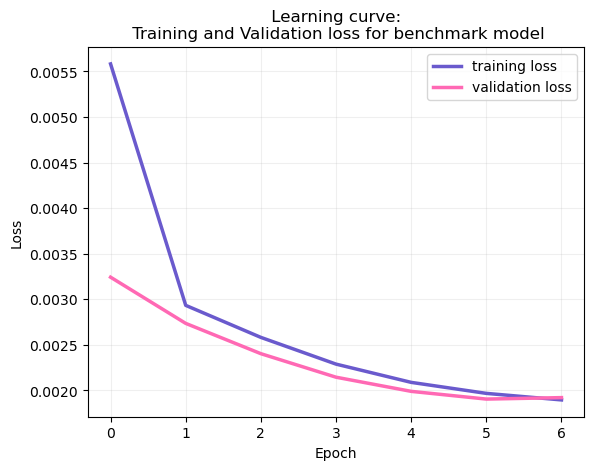

In [16]:

plt.plot(history.history['loss'], color = 'slateblue', linewidth=2.5)    # Add some colour into my life...
plt.plot(history.history['val_loss'] , color = 'hotpink', linewidth=2.5)    # Add even more colour into my life...
plt.title(' Learning curve: \n Training and Validation loss for benchmark model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss ', 'validation loss' ], loc='upper right')
plt.grid(alpha=0.2)
plt.show()

- The training loss is a metric used to assess how the model fits the training data
- The validation loss is a metric used to assess how the model performs on a validation set (e.g. a portion of the training set that was set aside)

- It looks as if the training loss converged.
- It's good that there isn't a large gap between the two losses as this means the model is able to generalize to new data.
- However because early stopping was implemented, the validation loss obviously started to go up indicating the model has started to overfit the standard model training data. 

So what will I fine tune:


What does adding more layers do:

|Parameter | Model: *2* | 
|---|---|
|**latent dim**|10|
|**# layers**|5|
|**optimizer**|Adam|
|**dense layers**|400, 200, 200, 100, 20|
|**activation**| sigmoid|
|**dropout**|None|

In [17]:
e_layers2 = [400, 200, 200, 100, 20, 10]

d_layers2 = [20, 100, 200, 200, 400]

enc2 = encoder(e_layers2, "relu", "adam", "mse")

dec2 = decoder(d_layers2, "relu", 10, "sigmoid")

ae2, history2 = autoencoder(enc2, dec2, 32, 30, "mse", "adam")

Epoch 1/30
8507/8507 [==============================] - 22s 2ms/step - loss: 0.0087 - val_loss: 0.0046
Epoch 2/30
8507/8507 [==============================] - 21s 2ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 3/30
8507/8507 [==============================] - 21s 2ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 4/30
8507/8507 [==============================] - 20s 2ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 5/30
8507/8507 [==============================] - 20s 2ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 6/30
8507/8507 [==============================] - 20s 2ms/step - loss: 0.0023 - val_loss: 0.0027


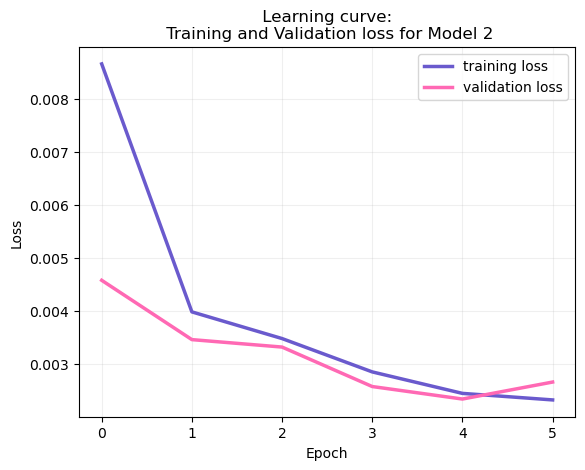

In [18]:
plt.plot(history2.history['loss'], color = 'slateblue', linewidth=2.5)    # Add some colour into my life...
plt.plot(history2.history['val_loss'] , color = 'hotpink', linewidth=2.5)    # Add even more colour into my life...
plt.title(' Learning curve: \n Training and Validation loss for Model 2')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss ', 'validation loss' ], loc='upper right')
plt.grid(alpha=0.2)
plt.show()

These a smaller losses but a sharp spike back up in validation loss

Changing the number of nodes in these 5 layers:

|Parameter | Model: *3* | 
|---|---|
|**latent dim**|10|
|**# layers**|5|
|**optimizer**|Adam|
|**dense layers**|200, 100, 50, 20, 15|
|**activation**| sigmoid|
|**dropout**|None|

In [19]:
e_layers3 = [200, 100, 50, 20, 15, 10]

d_layers3 = [15, 20, 50, 100, 200]

enc3 = encoder(e_layers3, "relu", "adam", "mse")

dec3 = decoder(d_layers3, "relu", 10, "sigmoid")

ae3, history3 = autoencoder(enc3, dec3, 32, 30, "mse", "adam")

Epoch 1/30
8507/8507 [==============================] - 12s 1ms/step - loss: 0.0139 - val_loss: 0.0109
Epoch 2/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 3/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0090 - val_loss: 0.0077
Epoch 4/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0063 - val_loss: 0.0064


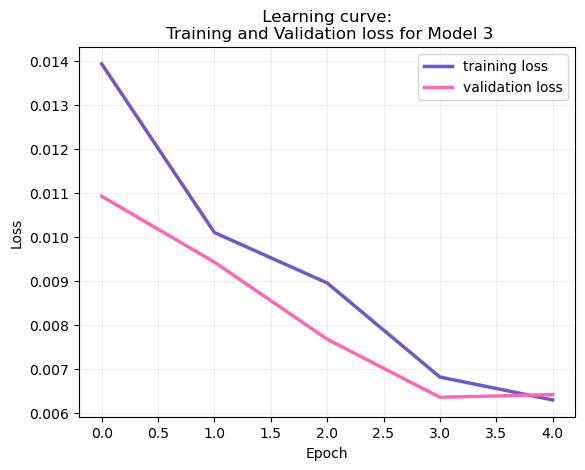

In [20]:
plt.plot(history3.history['loss'], color = 'slateblue', linewidth=2.5)    # Add some colour into my life...
plt.plot(history3.history['val_loss'] , color = 'hotpink', linewidth=2.5)    # Add even more colour into my life...
plt.title(' Learning curve: \n Training and Validation loss for Model 3')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss ', 'validation loss' ], loc='upper right')
plt.grid(alpha=0.2)
plt.show()

Definitely not a good model...

I'm going to revert back to the original benchmark model since this looked the most promising (and was probably also a benchmark model for a reason). This time I'll change some activation functions:

|Parameter | Model: *4* | 
|---|---|
|**latent dim**|10|
|**# layers**|5|
|**optimizer**|Adam|
|**dense layers**|400, 200, 200, 100, 20|
|**activation**| sigmoid|
|**dropout**|None|

In [21]:
e_layers4 = [200, 200, 20, 10]

d_layers4 = [20, 200, 200]

enc4 = encoder(e_layers4, "LeakyReLU", "adam", "mse")

dec4 = decoder(d_layers4, "LeakyReLU", 10, "sigmoid")

ae4, history4 = autoencoder(enc4, dec4, 32, 30, "mse", "adam")

Epoch 1/30
8507/8507 [==============================] - 12s 1ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 2/30
8507/8507 [==============================] - 12s 1ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/30
8507/8507 [==============================] - 12s 1ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/30
8507/8507 [==============================] - 12s 1ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 8/30
8507/8507 [==============================] - 12s 1ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/30
8507/8507 [==============================] - 12s 1ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 10/30
8507/8507 [==============================] - 12s 1ms/step - l

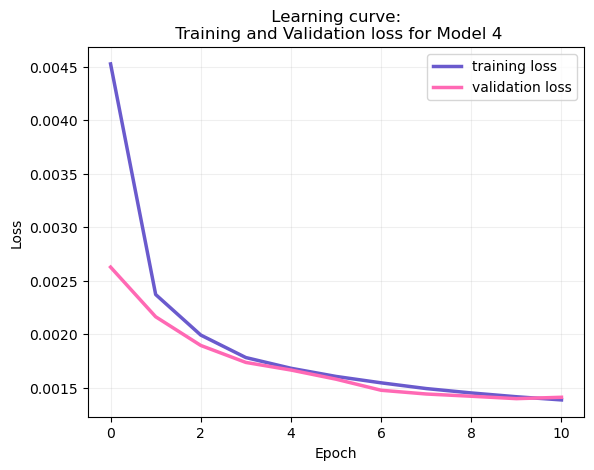

In [22]:
plt.plot(history4.history['loss'], color = 'slateblue', linewidth=2.5)    # Add some colour into my life...
plt.plot(history4.history['val_loss'] , color = 'hotpink', linewidth=2.5)    # Add even more colour into my life...
plt.title(' Learning curve: \n Training and Validation loss for Model 4')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss ', 'validation loss' ], loc='upper right')
plt.grid(alpha=0.2)
plt.show()

Using LeakyReLU works slightly better than just ReLU


|Parameter | Model: *5* | 
|---|---|
|**latent dim**|5|
|**# layers**|3|
|**optimizer**|Adam|
|**dense layers**|200, 100, 20|
|**activation**| sigmoid|
|**dropout**|None|

In [23]:
e_layers5 = [200, 100, 20, 5]

d_layers5 = [20, 100, 200]

enc5 = encoder(e_layers5, "LeakyReLU", "adam", "mse")

dec5 = decoder(d_layers5, "LeakyReLU", 5, "sigmoid")

ae5, history5 = autoencoder(enc5, dec5, 32, 30, "mse", "adam")

Epoch 1/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0095 - val_loss: 0.0072
Epoch 2/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 3/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 4/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 5/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 6/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 7/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0052 - val_loss: 0.0051
Epoch 8/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0051 - val_loss: 0.0051
Epoch 9/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 10/30
8507/8507 [==============================] - 10s 1ms/step - l

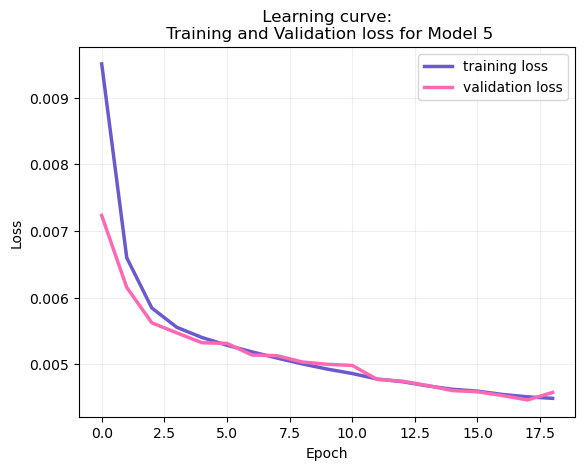

In [24]:
plt.plot(history5.history['loss'], color = 'slateblue', linewidth=2.5)    # Add some colour into my life...
plt.plot(history5.history['val_loss'] , color = 'hotpink', linewidth=2.5)    # Add even more colour into my life...
plt.title(' Learning curve: \n Training and Validation loss for Model 5')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss ', 'validation loss' ], loc='upper right')
plt.grid(alpha=0.2)
plt.show()

|Parameter | Model: *6* | 
|---|---|
|**latent dim**|30|
|**# layers**|3|
|**optimizer**|Adam|
|**dense layers**|100, 60, 30|
|**activation**| sigmoid|
|**dropout**|None|

In [25]:
e_layers6 = [100, 60, 30, 30]

d_layers6 = [30, 60, 100]

enc6 = encoder(e_layers6, "LeakyReLU", "adam", "mse")

dec6 = decoder(d_layers6, "LeakyReLU", 30, "sigmoid")

ae6, history6 = autoencoder(enc6, dec6, 32, 30, "mse", "adam")

Epoch 1/30
8507/8507 [==============================] - 8s 865us/step - loss: 0.0034 - val_loss: 0.0015
Epoch 2/30
8507/8507 [==============================] - 7s 833us/step - loss: 0.0010 - val_loss: 7.1637e-04
Epoch 3/30
8507/8507 [==============================] - 7s 832us/step - loss: 6.2633e-04 - val_loss: 4.8737e-04
Epoch 4/30
8507/8507 [==============================] - 7s 822us/step - loss: 4.2703e-04 - val_loss: 3.7623e-04
Epoch 5/30
8507/8507 [==============================] - 7s 824us/step - loss: 3.6930e-04 - val_loss: 3.5829e-04
Epoch 6/30
8507/8507 [==============================] - 7s 832us/step - loss: 3.2964e-04 - val_loss: 2.7894e-04
Epoch 7/30
8507/8507 [==============================] - 7s 821us/step - loss: 2.9037e-04 - val_loss: 3.1775e-04


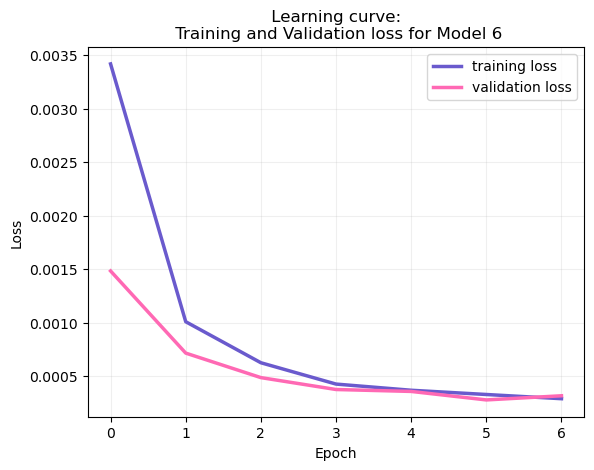

In [26]:
plt.plot(history6.history['loss'], color = 'slateblue', linewidth=2.5)    # Add some colour into my life...
plt.plot(history6.history['val_loss'] , color = 'hotpink', linewidth=2.5)    # Add even more colour into my life...
plt.title(' Learning curve: \n Training and Validation loss for Model 6')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss ', 'validation loss' ], loc='upper right')
plt.grid(alpha=0.2)
plt.show()

Best model so far...

|Parameter | Model: *7 (exact benchmark)* | 
|---|---|
|**latent dim**|10|
|**# layers**|3|
|**optimizer**|Adam|
|**dense layers**|200, 200, 20|
|**activation**| tanh|
|**dropout**|None|

In [27]:
e_layers7 = [200, 200, 20, 10]

d_layers7 = [20, 200, 200]

enc7 = encoder(e_layers7, "tanh", "adam", "mse")

dec7 = decoder(d_layers7, "tanh", 10, "tanh")

ae7, history7 = autoencoder(enc7, dec7, 32, 30, "mse", "adam")

Epoch 1/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 2/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 3/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 4/30
8507/8507 [==============================] - 11s 1ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 5/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 6/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/30
8507/8507 [==============================] - 10s 1ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/30
8507/8507 [==============================] - 10s 1ms/step - l

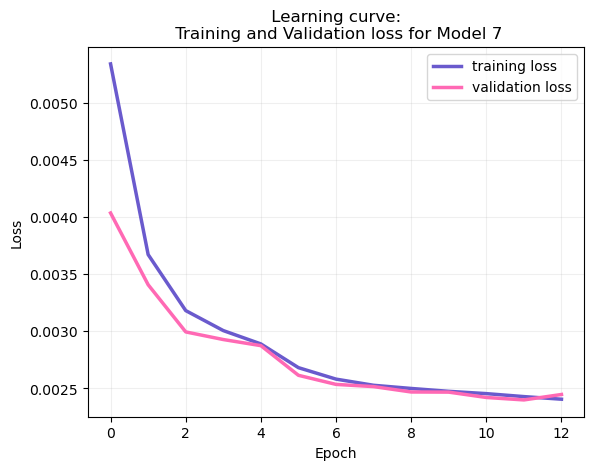

In [28]:
plt.plot(history7.history['loss'], color = 'slateblue', linewidth=2.5)    # Add some colour into my life...
plt.plot(history7.history['val_loss'] , color = 'hotpink', linewidth=2.5)    # Add even more colour into my life...
plt.title(' Learning curve: \n Training and Validation loss for Model 7')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss ', 'validation loss' ], loc='upper right')
plt.grid(alpha=0.2)
plt.show()

So tanh is not as good as relu here

##### Seeing what happens when I remove the early stopping callback...probably terrible things...

In [29]:
# Remove the early stopping callback

def autoencoder2(model_encoder, model_decoder, batch_size, epochs, loss, optimizer):

    ae = Model(inputs = model_encoder.input, outputs = model_decoder(model_encoder.output))

    ae.compile(loss = loss, optimizer = optimizer)

    history = ae.fit(train, train, batch_size = batch_size, epochs = epochs, validation_data = (test,test))

    return ae, history

In [30]:
ae8, history8 = autoencoder2(enc6, dec6, 32, 15, "mse", "adam")

Epoch 1/15
8507/8507 [==============================] - 8s 856us/step - loss: 2.5746e-04 - val_loss: 2.2937e-04
Epoch 2/15
8507/8507 [==============================] - 7s 813us/step - loss: 2.3698e-04 - val_loss: 2.2892e-04
Epoch 3/15
8507/8507 [==============================] - 7s 815us/step - loss: 2.1789e-04 - val_loss: 2.1165e-04
Epoch 4/15
8507/8507 [==============================] - 7s 815us/step - loss: 2.0268e-04 - val_loss: 1.7009e-04
Epoch 5/15
8507/8507 [==============================] - 7s 811us/step - loss: 1.8352e-04 - val_loss: 1.7046e-04
Epoch 6/15
8507/8507 [==============================] - 7s 839us/step - loss: 1.6754e-04 - val_loss: 1.4677e-04
Epoch 7/15
8507/8507 [==============================] - 7s 832us/step - loss: 1.8007e-04 - val_loss: 1.4145e-04
Epoch 8/15
8507/8507 [==============================] - 7s 841us/step - loss: 1.4489e-04 - val_loss: 1.5747e-04
Epoch 9/15
8507/8507 [==============================] - 7s 820us/step - loss: 1.3730e-04 - val_loss: 1.4

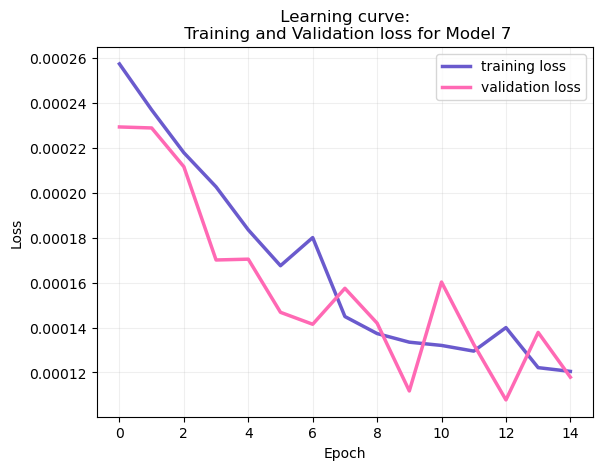

In [31]:
plt.plot(history8.history['loss'], color = 'slateblue', linewidth=2.5)    # Add some colour into my life...
plt.plot(history8.history['val_loss'] , color = 'hotpink', linewidth=2.5)    # Add even more colour into my life...
plt.title(' Learning curve: \n Training and Validation loss for Model 7')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss ', 'validation loss' ], loc='upper right')
plt.grid(alpha=0.2)
plt.show()

### Evaluating the BSM dataset

#### Using our trained Autoencoder:

Now that I have trained my autoencoders on the standard model data, when I feed new data in, it will try and reconstruct it in a manner that fits this 'standard model of particle physics'. If the BSM data contains any anomalies, or "particles that don't correspond to the standard model", when the autoencoder tries to reconstruct this data, there will be an abnormaly large loss for the model as the data it is predicting won't match the data it has been given. This is how I may detect anomalies in the BSM dataset. 


Here is my line of thinking for trying to detect anomalies in the BSM dataset:

- Create a function that records the mean squared error (mse) for each event ran through a model
- I can then plot a histogram of the mse for running both the SM and BSM through a particular model
- Hopefully then the histogram will look like an exponentially declining slope for the SM and then if the BSM data has any anomalies it will appear as a peak on top of the SM histogram

- I think I will pick two models to run all the data on so I can compare how each of them perform
- I'm thinking of using the 1st benchmark model that I ran, as it had a nice smooth learning curve with pretty good losses
- I think it would also be fun to use this as it's the first model from the paper
- I also want to pick the 6th model that I built as it had the lowest losses

Here are the two architectures:

|Parameter | Model: *Benchmark* | 
|---|---|
|**latent dim**|10|
|**# layers**|3|
|**optimizer**|Adam|
|**dense layers**|200, 200, 20|
|**activation**| sigmoid|
|**dropout**|None|




|Parameter | Model: *6* | 
|---|---|
|**latent dim**|30|
|**# layers**|3|
|**optimizer**|Adam|
|**dense layers**|100, 60, 30|
|**activation**| sigmoid|
|**dropout**|None|


In [32]:
# imported so that I could see how the progress is going
from tqdm.notebook import tqdm

In [33]:
# Calculates the MSE for a dataset ran through a given autoencoder
def MSE (model, dataset):

    mse_values = []       #create an empty list to store the calculated mse values in
    
    N = int(dataset.shape[0])    # number of events in the dataset
    
    for i in tqdm(range(0,N)):      # for loop to run through each event
        
        evaluate = dataset[i].reshape(1,39)
        evaluate2 = model.evaluate(evaluate,evaluate)   #running the dataset through the model
        mse_values.append(evaluate2)  #appending the loss/ mse values to our empty list
    
    return np.array(mse_values)

I want to run this function on the standard model/background data using model number 6

In [34]:
"""mse_sm_ae6 = MSE(ae6, test)"""

'mse_sm_ae6 = MSE(ae6, test)'

** I'm not running the above cell for my submission as it takes a VERY long time to run and also crashes jupyter notebook after only roughly 5% of the dataset. I think need to find an alternative way to find anomalies... **

I think the function above takes so long to run because it has a for loop.


Having another think I also think I should be using the tensflow method .predict() instead of .evaluate().
The evaluate method predicts the output, given the input, and then aslo computes the loss metrics which I guess will be computationally expensive when calculating for each batch/event. The predict method will just give me what the model predicts though based on my input. I can then therfore calculate the loss myself which will be a lot faster.

Below I have designed my new mean squared error function to calculate the loss manually.

In [35]:
def mse_calc(model, data):

    predict = model.predict(data)       # using the trained model to predict an output, given the input
    
    mse = np.mean(np.square(data - predict), axis=1)    # manually calculating the mean squared error
    
    return mse

In [36]:
mse_test = mse_calc(ae, test)

2127/2127 [==============================] - 1s 416us/step


In [37]:
mse_background = mse_calc(ae, scaled_background)

10634/10634 [==============================] - 5s 424us/step


In [38]:
mse_test_model6 = mse_calc(ae6, test)

2127/2127 [==============================] - 1s 406us/step


In [39]:
threshold6 = np.mean(mse_test_model6) + np.std(mse_test_model6)
print("Model 6 Threshold: ", threshold6)

Model 6 Threshold:  0.0005043370578189583


In [40]:
threshold = np.mean(mse_test) + np.std(mse_test)
print("Benchmark model Threshold: ", threshold)

Benchmark model Threshold:  0.004597673514768291


In [41]:
norm_mse_test = mse_test/len(mse_test)
norm_threshold = np.mean(norm_mse_test) + np.std(norm_mse_test)
print("Benchmark model Normalized Threshold: ", norm_threshold)

norm6_mse_test = mse_test_model6/len(mse_test_model6)
norm_threshold6 = np.mean(norm6_mse_test) + np.std(norm6_mse_test)
print("Model 6 Normalized Threshold: ", norm_threshold6)

Benchmark model Normalized Threshold:  6.755919585576588e-08
Model 6 Normalized Threshold:  7.410836362579104e-09


### pp24mt_50:
#### 50Gev Z' which decays to 4 leptons and neutrinos

### Benchmark Model:

In [42]:
mse_pp24 = mse_calc(ae, scaled_pp24)

266/266 [==============================] - 0s 520us/step


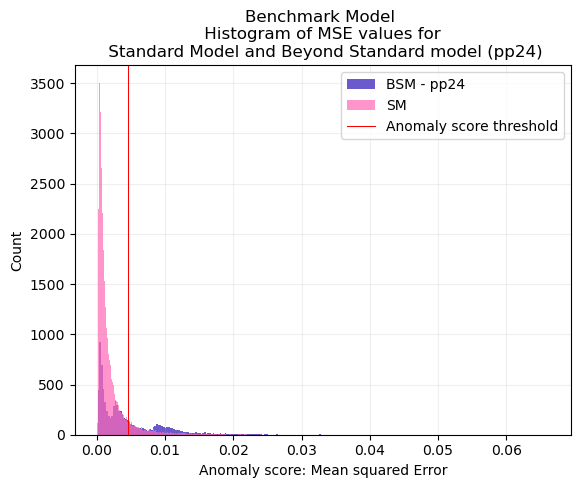

In [43]:
plt.hist(mse_pp24, bins=200, label='BSM - pp24', color='slateblue')
plt.hist(mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Histogram of MSE values for \n Standard Model and Beyond Standard model (pp24)") 

plt.legend()

plt.show()

To make the peaks in the BSM stand out more I made the bins sizes a lot smaller. This can be decieving though if the bin sizes are not the same.

In [44]:
# Find elements greater than the threshold
anompp24 = (mse_pp24 > threshold).sum()
print("The number of events in the BSM-pp24 dataset that are above the treshold and classified as anomalies is: ", anompp24)

The number of events in the BSM-pp24 dataset that are above the treshold and classified as anomalies is:  2817


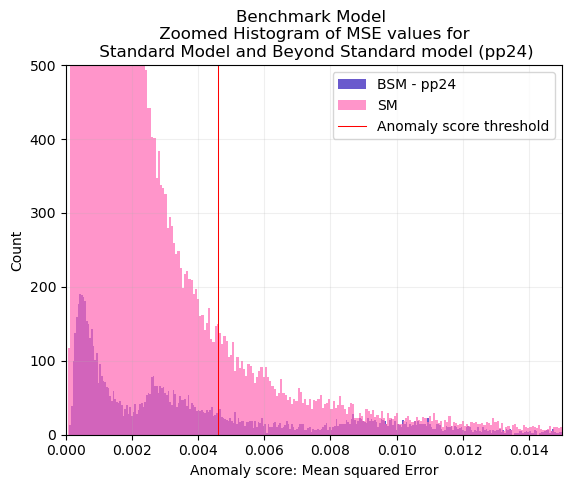

In [45]:
plt.hist(mse_pp24, bins=1000, label='BSM - pp24', color='slateblue')
plt.hist(mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Zoomed Histogram of MSE values for \n Standard Model and Beyond Standard model (pp24)") 

plt.xlim(0,0.015)
plt.ylim(0,500)

plt.show()

To get around the binsize problem I'm going to normalize both the datasets:

In [46]:
norm_mse_pp24 = mse_pp24/len(mse_pp24)

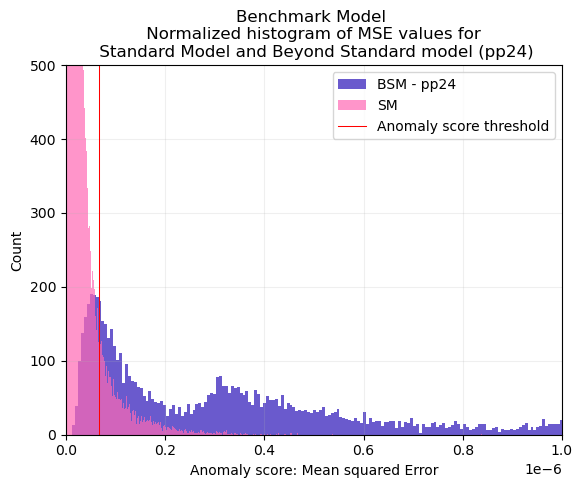

In [47]:
plt.hist(norm_mse_pp24, bins=1000, label='BSM - pp24', color='slateblue')
plt.hist(norm_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,1*10**-6)
plt.ylim(0,500)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (pp24)") 

plt.show()

### Model 6:

In [48]:
mse_pp24_6 = mse_calc(ae6, scaled_pp24)

266/266 [==============================] - 0s 409us/step


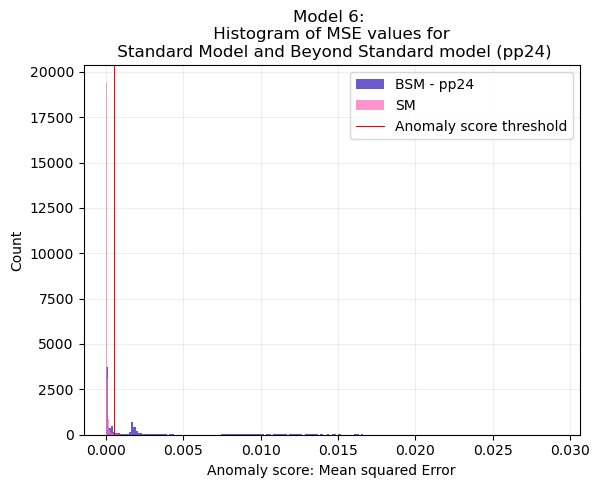

In [49]:
plt.hist(mse_pp24_6, bins=200, label='BSM - pp24', color='slateblue')
plt.hist(mse_test_model6, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6: \n Histogram of MSE values for \n Standard Model and Beyond Standard model (pp24)") 

plt.legend()

plt.show()

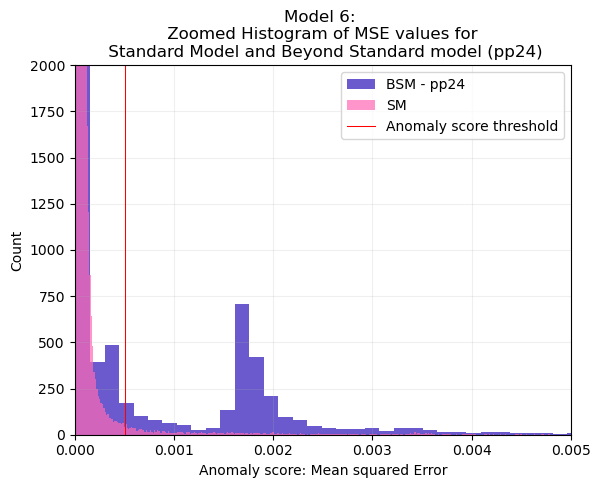

In [50]:
plt.hist(mse_pp24_6, bins=200, label='BSM - pp24', color='slateblue')
plt.hist(mse_test_model6, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6: \n Zoomed Histogram of MSE values for \n Standard Model and Beyond Standard model (pp24)") 

plt.legend()

plt.xlim(0, 0.005)
plt.ylim(0, 2000)

plt.show()

In [51]:
norm_mse_pp24_6 = mse_pp24_6/len(mse_pp24_6)

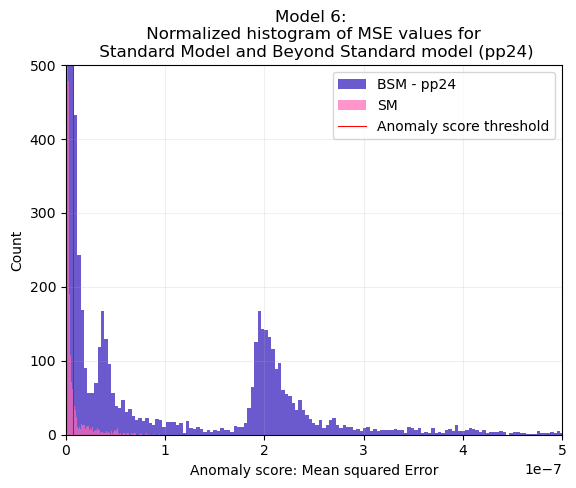

In [52]:
plt.hist(norm_mse_pp24_6, bins=1000, label='BSM - pp24', color='slateblue')
plt.hist(norm6_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,0.5*10**-6)
plt.ylim(0,500)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6: \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (pp24)") 

plt.show()

- For pp24, the benchmark model produced more consistent mse's
- Model 6 however produces a large peak of an anomaly score - perhaps indicating that this model worked better at detecting unusual data?

##### !!From now on I'm just going to plot the normalized graphs as this makes more sense. I will also change the axis scales to make the signal features more apparent!!

### chacha_cha300_neut140:
#### (neutral current pair production of 300Gev charginos which decay to a W and 140Gev neutralino)

### Benchmark Model:

In [53]:
mse_cha300 = mse_calc(ae, scaled_cha300)

21/21 [==============================] - 0s 768us/step


In [54]:
norm_mse_cha300 = mse_cha300/len(mse_cha300)

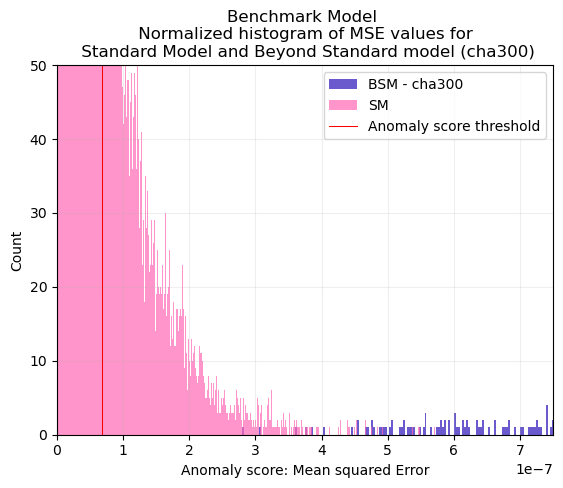

In [55]:
plt.hist(norm_mse_cha300, bins=10000, label='BSM - cha300', color='slateblue')
plt.hist(norm_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,0.75
         #
         *10**-6)
plt.ylim(0,50)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (cha300)") 

plt.show()

### Model 6:

In [56]:
mse_cha300_6 = mse_calc(ae6, scaled_cha300)

21/21 [==============================] - 0s 669us/step


In [57]:
norm_mse_cha300_6 = mse_cha300_6/len(mse_cha300_6)

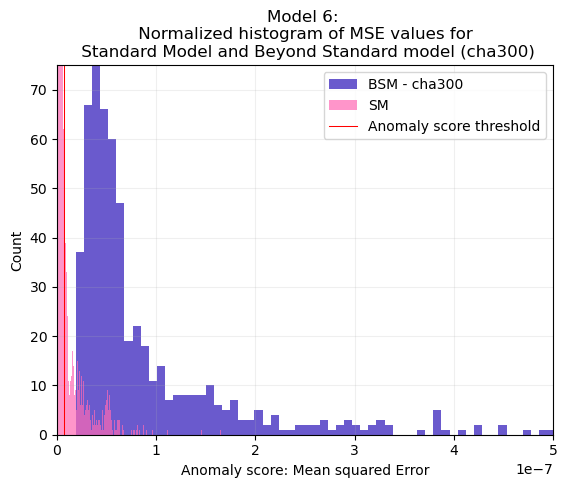

In [58]:
plt.hist(norm_mse_cha300_6, bins=1000, label='BSM - cha300', color='slateblue')
plt.hist(norm6_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,0.5*10**-6)
plt.ylim(0,75)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6: \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (cha300)") 

plt.show()

- For cha300, anomaly detections are hardly noticable in the benchmark model
- Model 6 produced a more rounded signal, again suggesting Model 6 worked better?

### chacha_cha400_neut60:
#### (neutral current pair production of 400 Gev charginos which decay to a W and 60 Gev neutralino)

##### Benchmark Model

In [59]:
mse_cha400 = mse_calc(ae, scaled_cha400)

27/27 [==============================] - 0s 757us/step


In [60]:
norm_mse_cha400 = mse_cha400/len(mse_cha400)

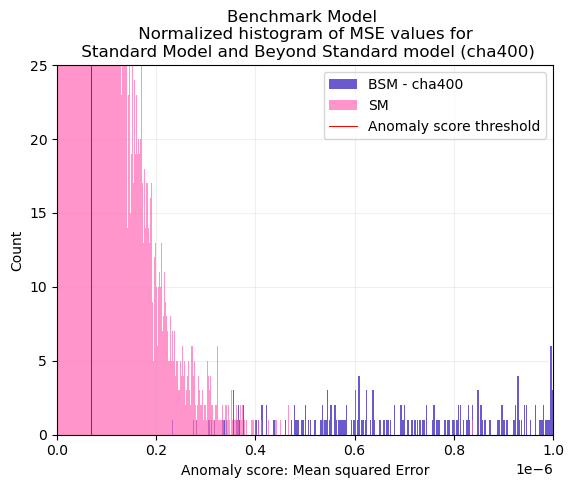

In [61]:
plt.hist(norm_mse_cha400, bins=10000, label='BSM - cha400', color='slateblue')
plt.hist(norm_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,1*10**-6)
plt.ylim(0,25)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (cha400)") 

plt.show()

##### Model 6

In [62]:
mse_cha400_6 = mse_calc(ae6, scaled_cha400)

27/27 [==============================] - 0s 708us/step


In [63]:
norm_mse_cha400_6 = mse_cha400_6/len(mse_cha400_6)

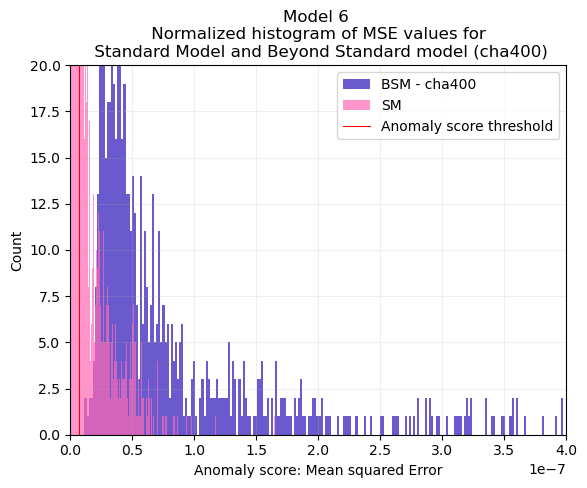

In [64]:
plt.hist(norm_mse_cha400_6, bins=10000, label='BSM - cha400', color='slateblue')
plt.hist(norm6_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,0.4*10**-6)
plt.ylim(0,20)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6 \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (cha400)") 

plt.show()

- Very little anomalies were detected for cha400 using the benchmark model
- Model 6 flagged up signal following the general shape of the standard model data however it is pretty noisy (probably due to my binsizes)

### chacha_cha600_neut200:
#### (neutral current pair production of 600Gev charginos which decay to a W and 200Gev neutralino)

##### Benchmark model

In [65]:
mse_cha600 = mse_calc(ae, scaled_cha600)

38/38 [==============================] - 0s 490us/step


In [66]:
norm_mse_cha600 = mse_cha600/len(mse_cha600)

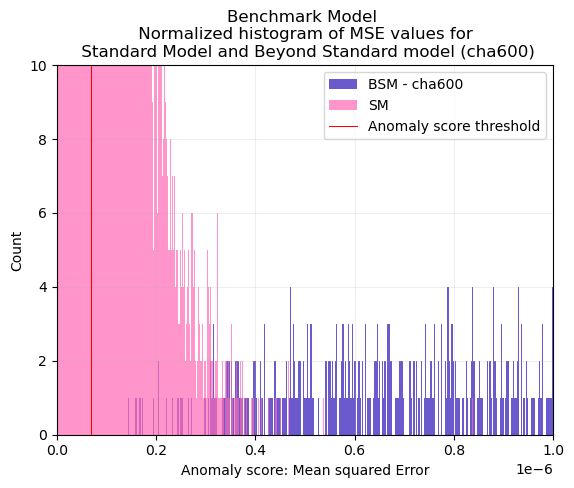

In [67]:
plt.hist(norm_mse_cha600, bins=10000, label='BSM - cha600', color='slateblue')
plt.hist(norm_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,1*10**-6)
plt.ylim(0,10)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (cha600)") 

plt.show()

##### Model 6

In [68]:
mse_cha600_6 = mse_calc(ae6, scaled_cha600)

38/38 [==============================] - 0s 452us/step


In [69]:
norm_mse_cha600_6 = mse_cha600_6/len(mse_cha600_6)

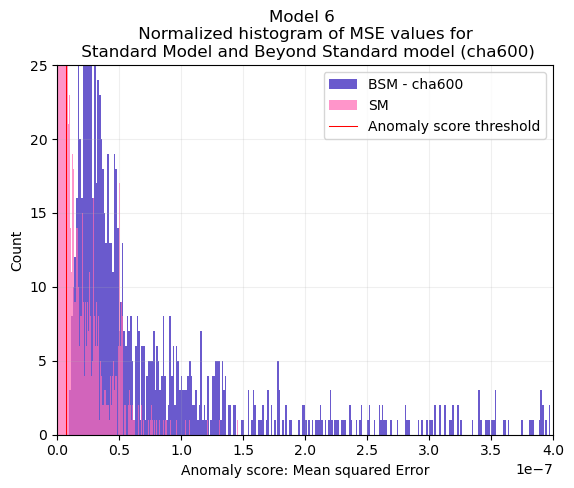

In [70]:
plt.hist(norm_mse_cha600_6, bins=10000, label='BSM - cha600', color='slateblue')
plt.hist(norm6_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,0.4*10**-6)
plt.ylim(0,25)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6 \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (cha600)") 

plt.show()

- Again the benchmark model doesn't produce much
- Model 6 produces something more interesting

### chaneut_cha200_neut50:
#### (charged current production of 50 Gev neutralinos and 200Gev charginos which decay to a W and neutralino)

##### Benchmark model

In [71]:
mse_cha200 = mse_calc(ae, scaled_cha200)

48/48 [==============================] - 0s 507us/step


In [72]:
norm_mse_cha200 = mse_cha200/len(mse_cha200)

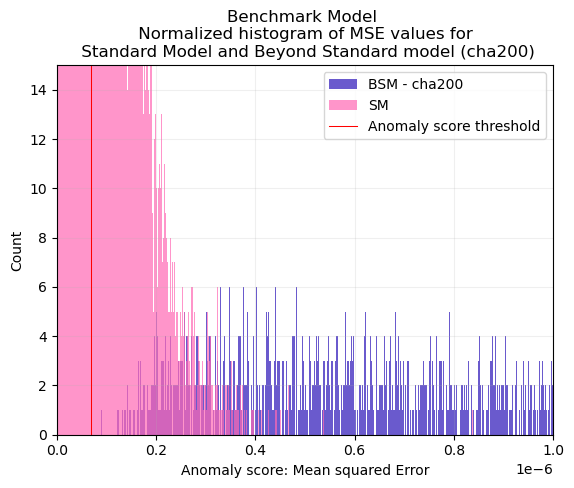

In [73]:
plt.hist(norm_mse_cha200, bins=10000, label='BSM - cha200', color='slateblue')
plt.hist(norm_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,1*10**-6)
plt.ylim(0,15)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (cha200)") 

plt.show()

##### Model 6

In [74]:
mse_cha200_6 = mse_calc(ae6, scaled_cha200)

48/48 [==============================] - 0s 561us/step


In [75]:
norm_mse_cha200_6 = mse_cha200_6/len(mse_cha200_6)

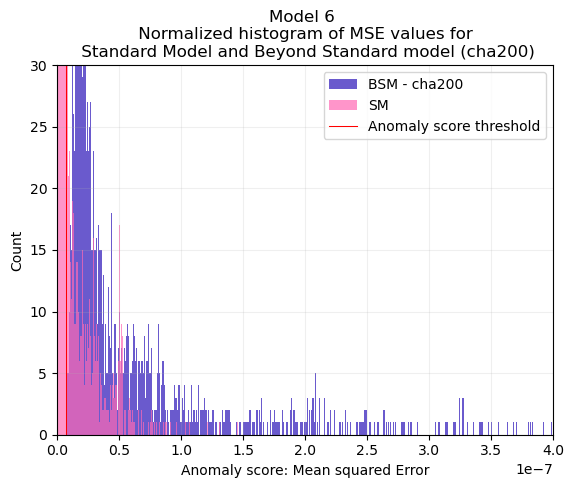

In [76]:
plt.hist(norm_mse_cha200_6, bins=10000, label='BSM - cha200', color='slateblue')
plt.hist(norm6_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,0.4*10**-6)
plt.ylim(0,30)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6 \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (cha200)") 

plt.show()

- Benchmark model gives pretty consistent numbers of anomaly scores
- Model 6 again follows the shape of the standard model data

### chaneut_cha250_neut150:
#### (charged current production of 150 Gev neutralinos and 250Gev charginos which decay to a W and neutralino)

##### Benchmark model

In [77]:
mse_cha250 = mse_calc(ae, scaled_cha250)

43/43 [==============================] - 0s 904us/step


In [78]:
norm_mse_cha250 = mse_cha250/len(mse_cha250)

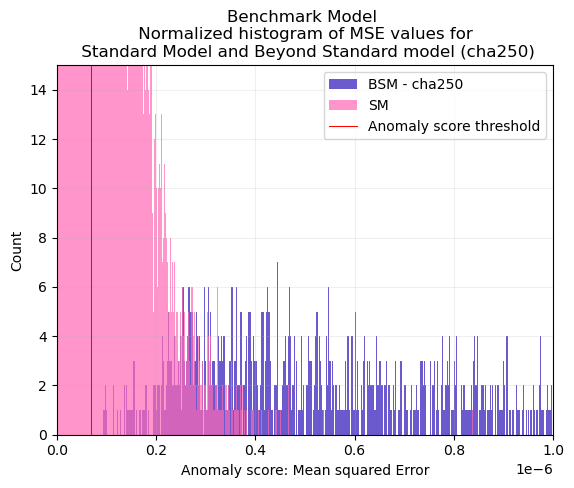

In [79]:
plt.hist(norm_mse_cha250, bins=10000, label='BSM - cha250', color='slateblue')
plt.hist(norm_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,1*10**-6)
plt.ylim(0,15)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (cha250)") 

plt.show()

##### Model 6

In [80]:
mse_cha250_6 = mse_calc(ae6, scaled_cha250)

43/43 [==============================] - 0s 952us/step


In [81]:
norm_mse_cha250_6 = mse_cha250_6/len(mse_cha250_6)

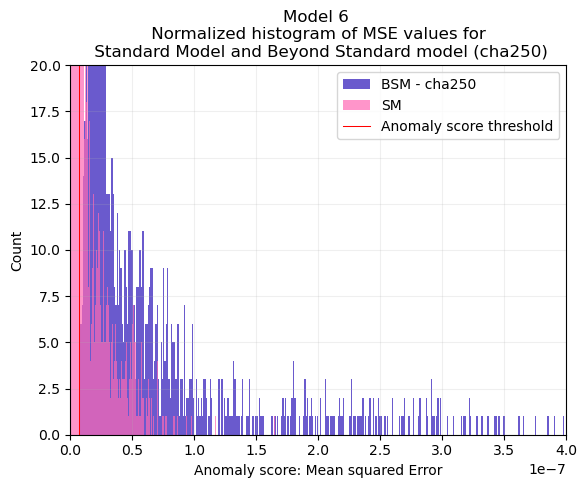

In [82]:
plt.hist(norm_mse_cha250_6, bins=10000, label='BSM - cha250', color='slateblue')
plt.hist(norm6_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,0.4*10**-6)
plt.ylim(0,20)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6 \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (cha250)") 

plt.show()


- Benchmark is again pretty constant
- Model 6 drops of like the standard model

### pp23mt_50:
#### 50Gev Z' which decays to 3 leptons and neutrinos

##### Benchmark model

In [83]:
mse_pp23 = mse_calc(ae, scaled_pp23)

107/107 [==============================] - 0s 728us/step


In [84]:
norm_mse_pp23 = mse_pp23/len(mse_pp23)

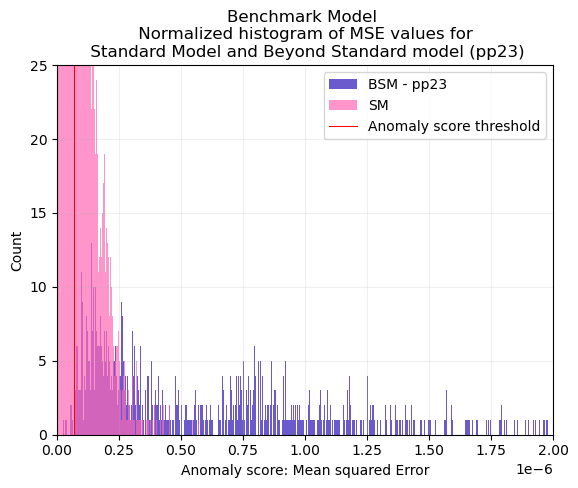

In [85]:
plt.hist(norm_mse_pp23, bins=10000, label='BSM - pp23', color='slateblue')
plt.hist(norm_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,2*10**-6)
plt.ylim(0,25)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (pp23)") 

plt.show()

##### Model 6

In [86]:
mse_pp23_6 = mse_calc(ae6, scaled_pp23)

107/107 [==============================] - 0s 536us/step


In [87]:
norm_mse_pp23_6 = mse_pp23_6/len(mse_pp23_6)

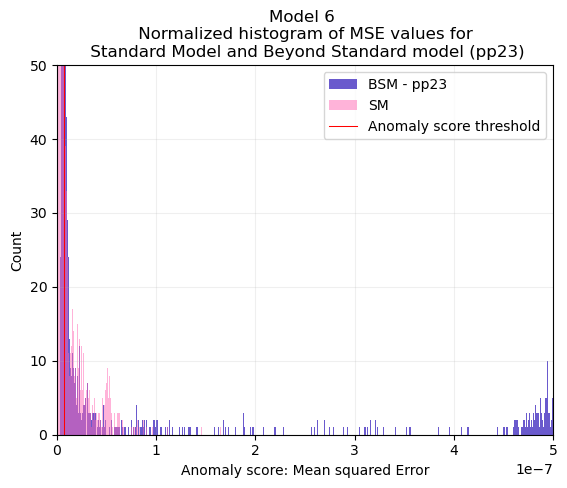

In [88]:
plt.hist(norm_mse_pp23_6, bins=10000, label='BSM - pp23', color='slateblue')
plt.hist(norm6_mse_test, bins=1000, label='SM', alpha=0.5, color='hotpink')
plt.axvline(x=norm_threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,0.5*10**-6)
plt.ylim(0,50)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6 \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (pp23)") 

plt.show()

- Benchmark model looks meh...
- Model 6 looks interesting!! Big peak aroun 4e-7

### stlp_st1000:
#### (stop-stop process which has a pair production of 1Tev supersymmetric stops which decay to leptons and b-quarks)

##### Benchmark Model

In [89]:
mse_stlp = mse_calc(ae, scaled_stlp)

426/426 [==============================] - 0s 453us/step


In [90]:
norm_mse_stlp = mse_stlp/len(mse_stlp)

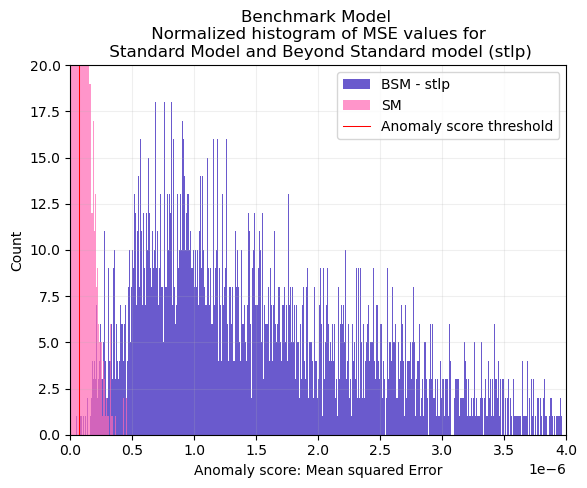

In [91]:
plt.hist(norm_mse_stlp, bins=10000, label='BSM - stlp', color='slateblue')
plt.hist(norm_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,4*10**-6)
plt.ylim(0,20)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (stlp)") 

plt.show()

##### Model 6

In [92]:
mse_stlp_6 = mse_calc(ae6, scaled_stlp)

426/426 [==============================] - 0s 388us/step


In [93]:
norm_mse_stlp_6 = mse_stlp_6/len(mse_stlp_6)

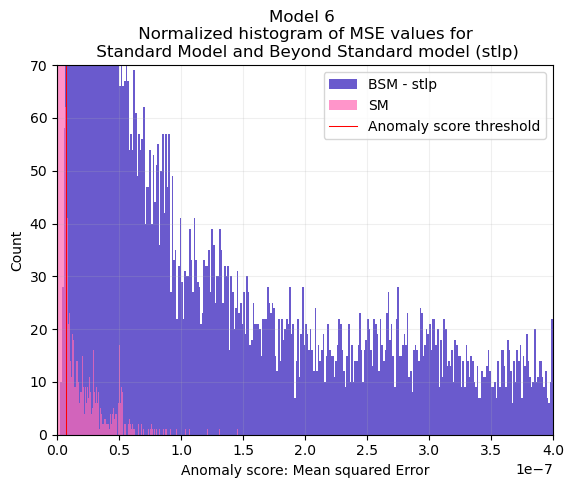

In [94]:

plt.hist(norm_mse_stlp_6, bins=10000, label='BSM - stlp', color='slateblue')
plt.hist(norm6_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,0.4*10**-6)
plt.ylim(0, 70)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6 \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (stlp)") 

plt.show()

- This is an interesting one. The first one where the benchmark model flags up a big guassian looking thing
- Model 6 has lots of anomaly scores but kind of following the tail distribution - still intersting though

### Conclusions of this long old mess of histograms...

The three intersting datasets that I've found from using the mse as anomaly scores is the stlp on Benchmark model and both pp23 and pp24 on model 6



### Looking at Signal Efficiencies

When comparing  different models for anomaly detection, calculating the signal effiency allows comparison of performance

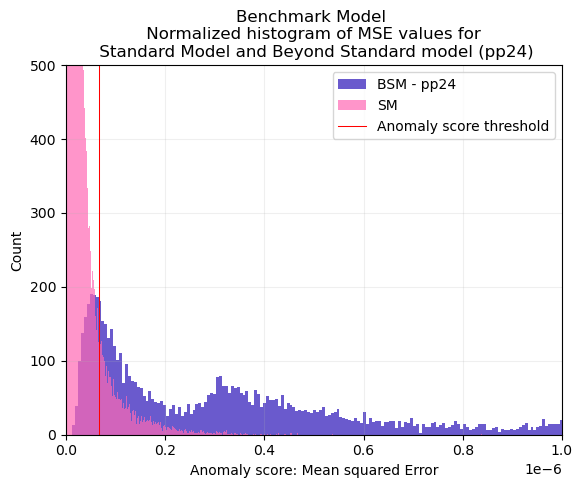

In [95]:

plt.hist(norm_mse_pp24, bins=1000, label='BSM - pp24', color='slateblue')
plt.hist(norm_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,1*10**-6)
plt.ylim(0,500)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Benchmark Model \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (pp24)") 

plt.show()

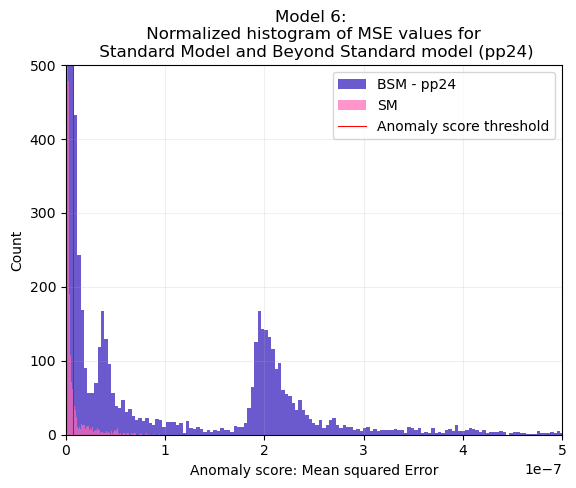

In [96]:

plt.hist(norm_mse_pp24_6, bins=1000, label='BSM - pp24', color='slateblue')
plt.hist(norm6_mse_test, bins=1000, label='SM', alpha=0.7, color='hotpink')
plt.axvline(x=norm_threshold6, linewidth=0.75, color='red', label='Anomaly score threshold')
plt.grid(alpha=0.2)
plt.xlim(0,0.5*10**-6)
plt.ylim(0,500)

plt.legend()

plt.xlabel("Anomaly score: Mean squared Error")
plt.ylabel("Count")
plt.title("Model 6: \n Normalized histogram of MSE values for \n Standard Model and Beyond Standard model (pp24)") 


plt.show()

In [97]:
sig = 0
back = 0

for i in norm_mse_pp24_6:

    if i >= norm_threshold6:

        sig += 1

    else:
        back +=1



efficiency = sig/(np.sqrt(sig+back))
efficiency

61.6010271940248

In [98]:
sig2 = 0
back2 = 0

for i in norm_mse_pp24:

    if i >= norm_threshold:

        sig2 += 1

    else:
        back2 +=1



efficiency2 = sig2/(np.sqrt(sig2+back2))
efficiency2

78.72869437827646

I expected the signal efficiency to be higher for model 6...

### Having run out of time ... here is a conclusion of my current findings:

#### Limitations:

- Because autoencoders are trained on "existing" or "standard model" data they may not necessarily perform well when presented with new/exotic particle data. Although this may have been flagged up in the reconstruction losses, a more sophisticated method which avoided this problem may have been used.
- Because autoencoders are unsupervised, the model may not have had the ability to distinguish between different types of particles/anomalies without the supervision/labels.
- The dimensionality of an autoencoder may have led to information losses which could have distinguished between a standard model particle and an anomaly.


#### Further Analysis:
- Significance improvement: In section 5.2.2 of the provided paper, the Significance Improvment metric (SI) was discussed as a way to tell how much an anomaly detector can enhance the statistical purity of the signal over the Standard Model noise. (Although to imply "new physics", the cross sections of the LHC process is needed)

#### Improvments:

- Optimising AE architecture: Using gridsearch as a tool to find the optimal hyper-parameters for my Autoencoder. Playing about with these hyperparameter was time-expensive so automating this would have been good.
- Find a more concrete way to distinguish what an anomaly is from the SM data. Just using events with an MSE above a threshold doesn't feel like enough.

## End of notebook